In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

IMPORT PORT DATA

In [2]:
ports_data = pd.read_csv(r"C:\Users\sneha.priya\OneDrive - WiseTech Global Pty Ltd\Desktop\DS\VDT model\DS Interview Assignment\DS Interview Assignment\Data for Assignment 1\csv_files\data3_ports.csv")

In [3]:
ports_data.head()

,PORTNAME,Terminal,Service Lane,Vessel,Voyage #,Arrival Time,Departure Time,Port Cut off Time
0,AARHUS,APM TERMINALS-AARHUS AS,SDX,AKACIA,1852E,31-12-2018 17:30,02-01-2019 12:04,30-12-2018 17:00
1,AARHUS,APM TERMINALS-AARHUS AS,IBC,ANNE SIBUM,014S,05-01-2019 13:09,05-01-2019 17:18,28-12-2018 14:00
2,AARHUS,APM TERMINALS-AARHUS AS,SDX,AKACIA,1901E,08-01-2019 06:06,08-01-2019 12:24,07-01-2019 17:00
3,AARHUS,APM TERMINALS-AARHUS AS,IBC,HELENA SCHEPERS,015S,12-01-2019 07:02,12-01-2019 14:30,08-01-2019 14:00
4,AARHUS,APM TERMINALS-AARHUS AS,SDX,AKACIA,1902W,15-01-2019 07:06,15-01-2019 14:04,14-01-2019 17:00


In [4]:
ports_data.isna().sum()

PORTNAME             0
Terminal             0
Service Lane         0
Vessel               0
Voyage #             0
Arrival Time         0
Departure Time       0
Port Cut off Time    0
dtype: int64

In [5]:
# Convert 'Arrival Time' and 'Departure Time' to datetime format
ports_data['Arrival Time'] = pd.to_datetime(ports_data['Arrival Time'], dayfirst=True)
ports_data['Departure Time'] = pd.to_datetime(ports_data['Departure Time'], dayfirst=True)

In [6]:
ports_data.columns

Index(['PORTNAME', 'Terminal', 'Service Lane', 'Vessel', 'Voyage #',
       'Arrival Time', 'Departure Time', 'Port Cut off Time'],
      dtype='object')

Feature check 1 - Unique vessels at each port

In [7]:
# vessel_each_port = ports_data.groupby(['PORTNAME'])['Vessel'].nunique().reset_index(name='Unique Vessels in each port')
# vessel_each_port

In [8]:
# port_data_1 = ports_data.merge(vessel_each_port, on= 'PORTNAME', how = 'left')

Feature check 2 - No. of Terminals at each port

In [9]:
# terminals_each_port = port_data_1.groupby('PORTNAME')['Terminal'].nunique().reset_index(name='Number of Terminals in each port')
# terminals_each_port

In [10]:
# port_data_2 = port_data_1.merge(terminals_each_port, on= 'PORTNAME', how = 'left')

In [11]:
# merged_data = pd.merge(vessels_per_port, terminals_per_port, on='PORTNAME')

# # Calculate the average number of vessels per terminal for each port
# merged_data['Vessels per Terminal'] = merged_data['Unique Vessels'] / merged_data['Number of Terminals']

# # To see the data aggregated at the port level, we can group by PORTNAME again and sum up the unique vessels,
# # then divide by the number of terminals to get the average number of vessels per terminal at the port level
# port_level_avg = merged_data.groupby('PORTNAME').agg({
#     'Unique Vessels': 'sum',
#     'Number of Terminals': 'mean',  # This should be the same for all rows of the same port
# }).reset_index()

# port_level_avg['Avg Vessels per Terminal'] = port_level_avg['Unique Vessels'] / port_level_avg['Number of Terminals']


# print(port_level_avg[['PORTNAME', 'Avg Vessels per Terminal']])

Merging port data and shipment+vessel data

In [12]:
port_data_cleaned = ports_data.rename(columns={
    'PORTNAME': 'DESTINATION_PORT',
    'Vessel': 'VESSEL',
    # 'Voyage #': 'VOYAGE#',
    'Arrival Time': 'ARRIVAL_TIME'
})

In [13]:
shipment_vessel = pd.read_csv(r'C:\Users\sneha.priya\OneDrive - WiseTech Global Pty Ltd\Desktop\DS\VDT model\DS Interview Assignment\DS Interview Assignment\Data for Assignment 1\csv_files\shipment_vessel.csv')

In [14]:
shipment_vessel.shape

(982, 17)

In [15]:
shipment_vessel['ARRIVAL_TIME'] = pd.to_datetime(shipment_vessel['ARRIVAL_TIME'],dayfirst=True)

In [16]:
shipment_vessel_port = shipment_vessel.merge(port_data_cleaned, how ='inner', on=['DESTINATION_PORT','VESSEL','ARRIVAL_TIME'])

In [17]:
shipment_vessel_port.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'VESSEL', 'IMO', 'ORIGIN_PORT',
       'DESTINATION_PORT', 'ARRIVAL_TIME', 'GATEOUT_TIME', 'HAZMAT',
       'IMPORT_DWELL', 'IMPORT_DWELL_SCALED', 'RF', 'Container_Size',
       'IS_WEEKEND', 'LENGTH', 'CLUSTER', 'VESSEL_CATEGORY', 'Terminal',
       'Service Lane', 'Voyage #', 'Departure Time', 'Port Cut off Time'],
      dtype='object')

In [18]:
shipment_vessel_port.shape

(970, 22)

VTT feature

In [19]:
# Calculate the VTT (Vessel Turnaround Time) in hours
shipment_vessel_port['VTT'] = (shipment_vessel_port['Departure Time'] - shipment_vessel_port['ARRIVAL_TIME']) / pd.Timedelta(hours=1)

In [20]:
shipment_vessel_port['VTT']

0       45.800000
1       45.800000
2       45.800000
3       45.800000
4       45.800000
          ...    
965    291.000000
966    205.233333
967     24.500000
968     24.500000
969     85.633333
Name: VTT, Length: 970, dtype: float64

In [21]:
correlation_matrix_VTT = shipment_vessel_port[['IMPORT_DWELL_SCALED', 'VTT','IMPORT_DWELL']].corr()
correlation_matrix_VTT

,IMPORT_DWELL_SCALED,VTT,IMPORT_DWELL
IMPORT_DWELL_SCALED,1.000000,0.290701,0.904860
VTT,0.290701,1.000000,0.218013
IMPORT_DWELL,0.904860,0.218013,1.000000


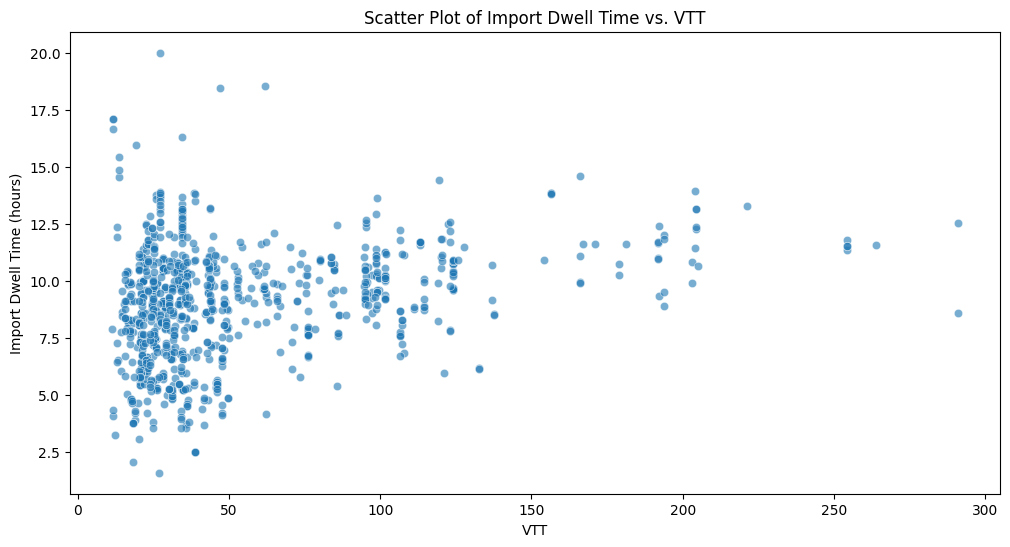

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=shipment_vessel_port, x="VTT", y="IMPORT_DWELL_SCALED", alpha=0.6)
plt.title('Scatter Plot of Import Dwell Time vs. VTT')
plt.xlabel('VTT')
plt.ylabel('Import Dwell Time (hours)')

plt.show()

In [23]:
shipment_vessel_port.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'VESSEL', 'IMO', 'ORIGIN_PORT',
       'DESTINATION_PORT', 'ARRIVAL_TIME', 'GATEOUT_TIME', 'HAZMAT',
       'IMPORT_DWELL', 'IMPORT_DWELL_SCALED', 'RF', 'Container_Size',
       'IS_WEEKEND', 'LENGTH', 'CLUSTER', 'VESSEL_CATEGORY', 'Terminal',
       'Service Lane', 'Voyage #', 'Departure Time', 'Port Cut off Time',
       'VTT'],
      dtype='object')

Feature - Avg berth time per port

In [24]:
average_berth_time_per_port = shipment_vessel_port.groupby('DESTINATION_PORT')['VTT'].mean().reset_index(name='AVERAGE_BERTH_TIME')

In [25]:
average_berth_time_per_port

,DESTINATION_PORT,AVERAGE_BERTH_TIME
0,CHARLESTON,19.226531
1,HAMBURG,41.600000
2,HONG KONG,17.120833
3,HONOLULU,85.633333
4,JACKSONVILLE,20.633333
5,LONG BEACH,117.253546
6,LOS ANGELES,123.327140
7,NEW YORK,41.090476
8,NORFOLK,25.135897
9,OAKLAND,48.410833


In [26]:
shipment_vessel_port = shipment_vessel_port.merge(average_berth_time_per_port, on='DESTINATION_PORT', how='left')

In [27]:
shipment_vessel_port[['IMPORT_DWELL_SCALED', 'AVERAGE_BERTH_TIME']].corr()

,IMPORT_DWELL_SCALED,AVERAGE_BERTH_TIME
IMPORT_DWELL_SCALED,1.000000,0.215829
AVERAGE_BERTH_TIME,0.215829,1.000000


In [28]:
# min(shipment_vessel_port['LENGTH'][(shipment_vessel_port['CLUSTER']==0)])

In [29]:
259-143

116

In [30]:
shipment_vessel_port.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'VESSEL', 'IMO', 'ORIGIN_PORT',
       'DESTINATION_PORT', 'ARRIVAL_TIME', 'GATEOUT_TIME', 'HAZMAT',
       'IMPORT_DWELL', 'IMPORT_DWELL_SCALED', 'RF', 'Container_Size',
       'IS_WEEKEND', 'LENGTH', 'CLUSTER', 'VESSEL_CATEGORY', 'Terminal',
       'Service Lane', 'Voyage #', 'Departure Time', 'Port Cut off Time',
       'VTT', 'AVERAGE_BERTH_TIME'],
      dtype='object')

In [31]:
shipment_vessel_port.head()

,Unnamed: 0.1,Unnamed: 0,VESSEL,IMO,ORIGIN_PORT,DESTINATION_PORT,ARRIVAL_TIME,GATEOUT_TIME,HAZMAT,IMPORT_DWELL,...,LENGTH,CLUSTER,VESSEL_CATEGORY,Terminal,Service Lane,Voyage #,Departure Time,Port Cut off Time,VTT,AVERAGE_BERTH_TIME
0,0,0,BELLAVIA,9290440,NAGOYA,TACOMA,2019-08-28 06:30:00,2019-08-29 13:11:00,0,30.683333,...,294,0,Medium,WUT (WASHINGTON UNITED TERMINALS),PN4,003W,2019-08-30 04:18:00,27-08-2019 16:00,45.8,60.251366
1,1,1,BELLAVIA,9290440,TOKYO,TACOMA,2019-08-28 06:30:00,2019-08-30 14:30:00,0,56.000000,...,294,0,Medium,WUT (WASHINGTON UNITED TERMINALS),PN4,003W,2019-08-30 04:18:00,27-08-2019 16:00,45.8,60.251366
2,2,55,BELLAVIA,9290440,TOKYO,TACOMA,2019-08-28 06:30:00,2019-09-03 09:46:00,0,147.266667,...,294,0,Medium,WUT (WASHINGTON UNITED TERMINALS),PN4,003W,2019-08-30 04:18:00,27-08-2019 16:00,45.8,60.251366
3,3,56,BELLAVIA,9290440,TOKYO,TACOMA,2019-08-28 06:30:00,2019-08-29 10:03:00,0,27.550000,...,294,0,Medium,WUT (WASHINGTON UNITED TERMINALS),PN4,003W,2019-08-30 04:18:00,27-08-2019 16:00,45.8,60.251366
4,4,57,BELLAVIA,9290440,TOKYO,TACOMA,2019-08-28 06:30:00,2019-08-29 10:38:00,0,28.133333,...,294,0,Medium,WUT (WASHINGTON UNITED TERMINALS),PN4,003W,2019-08-30 04:18:00,27-08-2019 16:00,45.8,60.251366


In [32]:
shipment_vessel_port['ARRIVAL_TIME'] = pd.to_datetime(shipment_vessel_port['ARRIVAL_TIME'])
shipment_vessel_port['GATEOUT_TIME'] = pd.to_datetime(shipment_vessel_port['GATEOUT_TIME'])

Feature - vessels coming in (departure and arrival window) on the basis of Port

In [33]:
port_level_arrivals = {port: 0 for port in shipment_vessel_port['DESTINATION_PORT'].unique()}

In [34]:
port_level_arrivals

{'TACOMA': 0,
 'NEW YORK': 0,
 'CHARLESTON': 0,
 'SAVANNAH': 0,
 'NORFOLK': 0,
 'JACKSONVILLE': 0,
 'SHANGHAI': 0,
 'OAKLAND': 0,
 'HONG KONG': 0,
 'SEATTLE': 0,
 'VANCOUVER': 0,
 'PUSAN': 0,
 'LOS ANGELES': 0,
 'LONG BEACH': 0,
 'TOKYO': 0,
 'SINGAPORE': 0,
 'ROTTERDAM': 0,
 'WILMINGTON': 0,
 'HAMBURG': 0,
 'YANTIAN': 0,
 'HONOLULU': 0}

In [35]:
for index, row in shipment_vessel_port.iterrows():
    arrival_time = row['ARRIVAL_TIME']
    departure_time = row['Departure Time']
    destination_port = row['DESTINATION_PORT']
    
    count = ((shipment_vessel_port['DESTINATION_PORT'] == destination_port) &
             (shipment_vessel_port['ARRIVAL_TIME'] >= arrival_time) & 
             (shipment_vessel_port['ARRIVAL_TIME'] <= departure_time)).sum()
    
    port_level_arrivals[destination_port] += count

In [36]:
port_level_arrivals

{'TACOMA': 316,
 'NEW YORK': 1375,
 'CHARLESTON': 367,
 'SAVANNAH': 891,
 'NORFOLK': 17,
 'JACKSONVILLE': 3,
 'SHANGHAI': 2023,
 'OAKLAND': 85,
 'HONG KONG': 4,
 'SEATTLE': 6,
 'VANCOUVER': 25,
 'PUSAN': 1,
 'LOS ANGELES': 1418,
 'LONG BEACH': 649,
 'TOKYO': 1,
 'SINGAPORE': 54,
 'ROTTERDAM': 1,
 'WILMINGTON': 5,
 'HAMBURG': 1,
 'YANTIAN': 1,
 'HONOLULU': 1}

In [37]:
port_level_arrivals_df = pd.DataFrame(list(port_level_arrivals.items()), columns=['DESTINATION_PORT', 'Total_Arrival_in_Window'])

In [38]:
port_level_arrivals_df

,DESTINATION_PORT,Total_Arrival_in_Window
0,TACOMA,316
1,NEW YORK,1375
2,CHARLESTON,367
3,SAVANNAH,891
4,NORFOLK,17
5,JACKSONVILLE,3
6,SHANGHAI,2023
7,OAKLAND,85
8,HONG KONG,4
9,SEATTLE,6


In [39]:
shipment_vessel_port_updated = shipment_vessel_port.merge(port_level_arrivals_df, on='DESTINATION_PORT', how='left')

In [40]:
shipment_vessel_port_updated[['Total_Arrival_in_Window','IMPORT_DWELL_SCALED']].corr()

,Total_Arrival_in_Window,IMPORT_DWELL_SCALED
Total_Arrival_in_Window,1.0000,0.2323
IMPORT_DWELL_SCALED,0.2323,1.0000


Feature- Total Terminals in port

In [41]:
terminals_per_port = shipment_vessel_port_updated.groupby('DESTINATION_PORT')['Terminal'].nunique().reset_index(name='Terminals_in_Port')
terminals_per_port

,DESTINATION_PORT,Terminals_in_Port
0,CHARLESTON,1
1,HAMBURG,1
2,HONG KONG,1
3,HONOLULU,1
4,JACKSONVILLE,1
5,LONG BEACH,1
6,LOS ANGELES,4
7,NEW YORK,3
8,NORFOLK,2
9,OAKLAND,2


In [42]:
shipment_vessel_port_final = shipment_vessel_port_updated.merge(terminals_per_port, how='left', on='DESTINATION_PORT')

In [43]:
shipment_vessel_port_final[['Terminals_in_Port','IMPORT_DWELL_SCALED']].corr()

,Terminals_in_Port,IMPORT_DWELL_SCALED
Terminals_in_Port,1.000000,0.268654
IMPORT_DWELL_SCALED,0.268654,1.000000


In [44]:
# correlation_matrix = shipment_vessel_port_updated[['IMPORT_DWELL_SCALED', 'Terminals_in_Port', 'Vessels_at_Port', 'Vessels_per_Terminal_in_Window','Arrival_in_Window','Arrival_Ratio_Terminal_to_Port']].corr()

In [45]:
# correlation_matrix

number of unique vessel in terminal / total number of unique vessels visited in that port

In [46]:
# count unique VESSEL in terminal
unique_vessels_per_terminal = shipment_vessel_port_final.groupby(['DESTINATION_PORT', 'Terminal'])['VESSEL'].nunique().reset_index(name='UNIQUE_VESSELS_PER_TERMINAL')

In [47]:
# count unique VESSEL in port
total_unique_vessels_per_port = shipment_vessel_port_final.groupby('DESTINATION_PORT')['VESSEL'].nunique().reset_index(name='TOTAL_UNIQUE_VESSELS')

In [48]:
unique_vessels_per_terminal = unique_vessels_per_terminal.merge(total_unique_vessels_per_port, on='DESTINATION_PORT', how='left')

In [49]:
# Calculate the ratio of unique vessels per terminal to total unique vessels at the port
unique_vessels_per_terminal['UNIQUE_VESSELS_RATIO'] = unique_vessels_per_terminal['UNIQUE_VESSELS_PER_TERMINAL'] / unique_vessels_per_terminal['TOTAL_UNIQUE_VESSELS']

In [50]:
shipment_vessel_port_final = shipment_vessel_port_final.merge(unique_vessels_per_terminal[['DESTINATION_PORT', 'Terminal', 'UNIQUE_VESSELS_RATIO']], on=['DESTINATION_PORT', 'Terminal'], how='left')

In [51]:
shipment_vessel_port_final[['UNIQUE_VESSELS_RATIO','IMPORT_DWELL_SCALED']].corr()

,UNIQUE_VESSELS_RATIO,IMPORT_DWELL_SCALED
UNIQUE_VESSELS_RATIO,1.000000,-0.251018
IMPORT_DWELL_SCALED,-0.251018,1.000000


total number of arrival at terminal1 / total number of arrivals at port

In [52]:
# Group by both DESTINATION_PORT and Terminal, then count the number of arrivals
arrivals_per_terminal = shipment_vessel_port_final.groupby(['DESTINATION_PORT', 'Terminal']).size().reset_index(name='TOTAL_ARRIVALS_PER_TERMINAL')

In [53]:
arrivals_per_terminal

,DESTINATION_PORT,Terminal,TOTAL_ARRIVALS_PER_TERMINAL
0,CHARLESTON,WWT (WANDO WELCH TERMINAL),49
1,HAMBURG,CTA (CONTAINER TERMINAL ALTENWERDER),1
2,HONG KONG,HIT (HONGKONG INTERNATIONAL TERMINALS ),4
3,HONOLULU,PIER 1 - PORT OF HONOLULU,1
4,JACKSONVILLE,TRAPAC JACKSONVILLE,3
5,LONG BEACH,ITS (INTL TRANSPORTATION SERVICES),47
6,LOS ANGELES,APM TERMINALS LA (MARINE),7
7,LOS ANGELES,TRAPAC LOS ANGELES,35
8,LOS ANGELES,WBCT (WEST BASIN CONTAINER TERMINAL),14
9,LOS ANGELES,YTI (YUSEN TERMINAL INTL),92


In [54]:
# Group by DESTINATION_PORT, then count the number of arrivals
total_arrivals_per_port = shipment_vessel_port_final.groupby('DESTINATION_PORT').size().reset_index(name='TOTAL_ARRIVALS_AT_PORT')

In [55]:
# Merge total arrivals per port with the arrivals per terminal DataFrame
arrivals_per_terminal = arrivals_per_terminal.merge(total_arrivals_per_port, on='DESTINATION_PORT', how='left')

In [56]:
# Calculate the ratio of arrivals per terminal to total arrivals at the port
arrivals_per_terminal['ARRIVALS_RATIO'] = arrivals_per_terminal['TOTAL_ARRIVALS_PER_TERMINAL'] / arrivals_per_terminal['TOTAL_ARRIVALS_AT_PORT']

In [57]:
# Merge the ratio back to the original dataset
shipment_vessel_port_final = shipment_vessel_port_final.merge(arrivals_per_terminal[['DESTINATION_PORT', 'Terminal', 'ARRIVALS_RATIO']], on=['DESTINATION_PORT', 'Terminal'], how='left')

In [58]:
shipment_vessel_port_final[['ARRIVALS_RATIO','IMPORT_DWELL_SCALED']].corr()

,ARRIVALS_RATIO,IMPORT_DWELL_SCALED
ARRIVALS_RATIO,1.00000,-0.26426
IMPORT_DWELL_SCALED,-0.26426,1.00000


In [59]:
shipment_vessel_port_final.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'VESSEL', 'IMO', 'ORIGIN_PORT',
       'DESTINATION_PORT', 'ARRIVAL_TIME', 'GATEOUT_TIME', 'HAZMAT',
       'IMPORT_DWELL', 'IMPORT_DWELL_SCALED', 'RF', 'Container_Size',
       'IS_WEEKEND', 'LENGTH', 'CLUSTER', 'VESSEL_CATEGORY', 'Terminal',
       'Service Lane', 'Voyage #', 'Departure Time', 'Port Cut off Time',
       'VTT', 'AVERAGE_BERTH_TIME', 'Total_Arrival_in_Window',
       'Terminals_in_Port', 'UNIQUE_VESSELS_RATIO', 'ARRIVALS_RATIO'],
      dtype='object')

In [60]:
shipment_vessel_port_final.to_csv('final_data.csv')